In [1]:
%%capture
%run utils.ipynb
import warnings
warnings.filterwarnings("ignore")

Most of the utility functions are implemented in 'utils.ipynb'. 

# Data

S&P500 call options with different strike prices and maturities. 
* Sheets: different maturities (total 12)
* Columns: different strike prices
* Rows: time series of price evolution

In addition
* 1st column: days to maturity
* 3rd last column: spot price of S&P500 index (1000 units)
* 2nd last column: riskless interest rate

Note: prices of call are per 1000 units (as are spot prices for underlying)

In [2]:
xls = pd.ExcelFile('isx2010C.xls')
isx15012010C = pd.read_excel(xls, 'isx15012010C')
isx15012010C.rename(columns={isx15012010C.columns[0]:'days_to_mat',isx15012010C.columns[48]:'sp500_spot',isx15012010C.columns[49]:'rf'},inplace=True)

For example data for call option maturing at 15.01.2010

In [3]:
isx15012010C.head()

,days_to_mat,340,345,350,355,360,365,370,375,380,...,540,545,550,555,560,565,570,sp500_spot,rf,date
0,86,152.20,NaN,NaN,NaN,132.60,NaN,NaN,NaN,113.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,491.34,0.11,21.9.2009
1,85,155.05,NaN,NaN,NaN,135.35,NaN,NaN,NaN,115.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,494.35,0.11,22.9.2009
2,84,152.40,NaN,NaN,NaN,132.70,NaN,NaN,NaN,113.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,490.36,0.11,23.9.2009
3,83,147.00,NaN,NaN,NaN,127.25,NaN,NaN,NaN,108.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,486.99,0.11,24.9.2009
4,82,145.55,NaN,NaN,NaN,125.95,NaN,NaN,NaN,106.75,...,3.8,NaN,NaN,NaN,1525.0,NaN,NaN,484.11,0.11,25.9.2009


# Hedging

The fundamental idea of hedging is to immunize the current position in derivative instruments against changes in the underlying asset. Hedging is set up by taking an opposite position in the underlying (i.e. long call, short asset). The size of the hedging positon is dependent on **the hedging strategy** used.

Various hedging strategies are considered below.

### Accuracy of hedging

Hedging strategy can be measured by the average accuracy of the hedge. Let $P_t$ be the derivative portfolio and $R_t$ the replicating (hedge) portfolio.

$$MSE=\frac{1}{N}\sum_{i=1}^N\big(dP_i-dR_i\big)^2$$

# Delta hedging (single option)

Delta hedging is set up as following

$$P_t=C_t-\Delta_t S_t$$

that is, portfolio $P_t$ consists being long call ($C_t:=$ price of an call at $t$) and short $\Delta$-units of the underlying ($S_t:=$ price of the underlying at $t$).

Now at time $t=0$, we form the portfolio

$$P_0=C_0-\Delta_0 S_0$$

Given our **rehedging frequency** k, the portfolio is rehedged. That is new $\Delta_{0+k}$ is calculated at time $t=k$ and corresponding portfolio $P_{0+k}$ is formed. Note: Variations in $C_t$ and $S_t$ are stochastic.

Delta is calculated by solving **implied volatility** from $C_t$ and using this to compute $\Delta_t$

### Data

Consider an at-the-money (ATM) option, maturing at 15.01.2010. As suggested in the assignment, let $t_0=$ 45 days to maturity.

In [5]:
isx_m45 = isx15012010C[isx15012010C.shape[0]-45:]
isx_m45.iloc[0]['sp500_spot'] # S&P500 spot

516.09

Since at $t_0$: $S_0=516.09$, call with $E=515$ is closest we can get to ATM. However, price series for this option is not complete (consists NaN values). Hence $E=520$ is chosen, which is in-the-money (ITM).

In [6]:
isx_m45_E520 = isx_m45[['days_to_mat',520,'sp500_spot','rf']].reset_index()
isx_m45_E520.head()

,index,days_to_mat,520,sp500_spot,rf
0,41,45,13.3,516.09,0.07
1,42,44,13.8,516.54,0.07
2,43,43,10.2,510.35,0.07
3,44,42,9.5,508.79,0.04
4,45,41,11.6,516.00,0.04


### Results

Solve implied volatility for each time step $t$.

In [8]:
isx_m45_E520['implied_vola'] = isx_m45_E520.apply(implied_vola_rows, axis=1)

Maximum iterations reached. Solution is NOT within the error bound.


Solve delta for each time step $t$.

In [19]:
isx_m45_E520['delta'] = isx_m45_E520.apply(delta_rows, axis=1)
isx_m45_E520_general = isx_m45_E520

Set rows for corresponding rehedging frequency. Here rehedging frequency $k=2$.

In [10]:
isx_m45_E520['delta_freq'] = set_rehedge_freq(2,isx_m45_E520['delta']) # rehedging frequency = 2
isx_m45_E520['hedge_pos'] = isx_m45_E520.apply(lambda row: row['sp500_spot']*row['delta_freq'],axis=1)
isx_m45_E520['change_P'] = isx_m45_E520[520].diff()
isx_m45_E520['change_R'] = isx_m45_E520['hedge_pos'].diff()
isx_m45_E520['MSE'] = isx_m45_E520.apply(lambda row: (row['change_P']-row['change_R'])**2,axis=1)

In [11]:
isx_m45_E520.head()

,index,days_to_mat,520,sp500_spot,rf,implied_vola,delta,delta_freq,hedge_pos,change_P,change_R,MSE
0,41,45,13.3,516.09,0.07,0.181326,0.563495,0.563495,290.814061,NaN,NaN,NaN
1,42,44,13.8,516.54,0.07,0.187510,0.561783,0.563495,291.067633,0.5,0.253573,0.060726
2,43,43,10.2,510.35,0.07,0.187954,0.556205,0.556205,283.859203,-3.6,-7.208430,13.020766
3,44,42,9.5,508.79,0.04,0.202831,0.531685,0.556205,282.991524,-0.7,-0.867680,0.028116
4,45,41,11.6,516.00,0.04,0.181000,0.538508,0.538508,277.870385,2.1,-5.121139,52.144849


In [12]:
isx_m45_E520['MSE'].sum()/isx_m45_E520['MSE'].count() # Average hedging (square) error

14.243354435562669

Delta hedging isx15012010C, $E=520$ with rehedging frequency $k=2$: $MSE=14.24$

With different rehedging frequencies:

$k=3$

In [13]:
isx_m45_E520['delta_freq'] = set_rehedge_freq(3,isx_m45_E520['delta'])
isx_m45_E520.head()

,index,days_to_mat,520,sp500_spot,rf,implied_vola,delta,delta_freq,hedge_pos,change_P,change_R,MSE
0,41,45,13.3,516.09,0.07,0.181326,0.563495,0.563495,290.814061,NaN,NaN,NaN
1,42,44,13.8,516.54,0.07,0.187510,0.561783,0.563495,291.067633,0.5,0.253573,0.060726
2,43,43,10.2,510.35,0.07,0.187954,0.556205,0.563495,283.859203,-3.6,-7.208430,13.020766
3,44,42,9.5,508.79,0.04,0.202831,0.531685,0.531685,282.991524,-0.7,-0.867680,0.028116
4,45,41,11.6,516.00,0.04,0.181000,0.538508,0.531685,277.870385,2.1,-5.121139,52.144849


In [14]:
isx_m45_E520['hedge_pos'] = isx_m45_E520.apply(lambda row: row['sp500_spot']*row['delta_freq'],axis=1)
isx_m45_E520['change_P'] = isx_m45_E520[520].diff()
isx_m45_E520['change_R'] = isx_m45_E520['hedge_pos'].diff()
isx_m45_E520['MSE'] = isx_m45_E520.apply(lambda row: (row['change_P']-row['change_R'])**2,axis=1)
isx_m45_E520['MSE'].sum()/isx_m45_E520['MSE'].count() # Average hedging (square) error 

12.78324553159768

$k=5$

In [15]:
isx_m45_E520['delta_freq'] = set_rehedge_freq(5,isx_m45_E520['delta'])
isx_m45_E520['hedge_pos'] = isx_m45_E520.apply(lambda row: row['sp500_spot']*row['delta_freq'],axis=1)
isx_m45_E520['change_P'] = isx_m45_E520[520].diff()
isx_m45_E520['change_R'] = isx_m45_E520['hedge_pos'].diff()
isx_m45_E520['MSE'] = isx_m45_E520.apply(lambda row: (row['change_P']-row['change_R'])**2,axis=1)
isx_m45_E520['MSE'].sum()/isx_m45_E520['MSE'].count()

13.406127827750847

To generalize the results, lets plot $MSE$ as a function of rehedging frequency $k$ for isx15012010C, $E=520$.

In [16]:
def MSE_for_freq(k,data):
    data['delta_freq'] = set_rehedge_freq(k,data['delta'])
    data['hedge_pos']  = data.apply(lambda row: row['sp500_spot']*row['delta_freq'],axis=1)
    data['change_P']   = data[520].diff()
    data['change_R']   = data['hedge_pos'].diff()
    data['MSE']        = data.apply(lambda row: (row['change_P']-row['change_R'])**2,axis=1)
    return data['MSE'].sum()/isx_m45_E520['MSE'].count() 

Text(0.5, 0, 'Rehedging frequency')

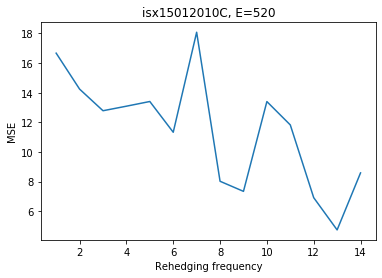

In [23]:
mses = [MSE_for_freq(x,isx_m45_E520_general) for x in range(1,15)]
plt.plot(range(1,15),mses)
plt.title("isx15012010C, E=520")
plt.ylabel("MSE")
plt.xlabel("Rehedging frequency")